# Test the API

## Setup Workspace

In [1]:
# dependencies
import os
import requests
import subprocess
from pathlib import Path
from PIL import Image
from collections import namedtuple


## Host the API

You first need to host the API.
In the next cell, you can check if you already built the docker image.

In [2]:
# check if the docker image exists
# define function to check
def check_docker_image():
    """Check if the docker image exists"""
    cmd = ["docker", "images", "-q", "muffin_vs_chihuahua_api"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    return bool(result.stdout.strip())

# get the result
docker_image_exists = check_docker_image()

# print message based on whether image exists
if docker_image_exists:
    print("✓ docker image 'muffin_vs_chihuahua_api' exists")
else:
    print("✗ docker image 'muffin_vs_chihuahua_api' not found")
    print("  build it with: docker build -t muffin_vs_chihuahua_api .")

✓ docker image 'muffin_vs_chihuahua_api' exists


If it does not exist, you can build it by running the following cell.

In [3]:
# if the image does not exist, it is built by running this cell
if not docker_image_exists:
    !docker build -t muffin_vs_chihuahua_api ..


Now, you can run the API in a fresh terminal from the parent directory.

1. Open a terminal
2. Navigate to the directory where the `Dockerfile` is located:
`muffin_vs_chihuahua`
3. Run the following command:

## 🔥 Hey! You **must** run this step **outside** the notebook! 🔥
#### 🔥 If you don't, run this, the API will not be hosted and the requests will fail! 🔥

```bash
docker run -p 8000:8000 muffin_vs_chihuahua_api
```

## Setup Requests

In [4]:
# Data structures
# ---------------

Muffin = namedtuple(
    "Muffin",
    ["a", "b", "c", "d"]
)

Chihuahua = namedtuple(
    "Chihuahua",
    ["a", "b", "c", "d"]
)


# Paths and URLs
# --------------

# endpoint of your API
url = "http://localhost:8000/predict"

# paths
DATA_DIR = Path("../data/processed/test")
MUFFINS = DATA_DIR / "muffin"
CHIHUAHUAS = DATA_DIR / "chihuahua"

# example images
muffin = Muffin(
    MUFFINS / "img_0_105.jpg",
    MUFFINS / "img_1_60.jpg",
    MUFFINS / "img_2_523.jpg",
    MUFFINS / "img_4_1017.jpg"
)

chihuahua = Chihuahua(
    CHIHUAHUAS / "img_0_18.jpg",
    CHIHUAHUAS / "img_1_144.jpg",
    CHIHUAHUAS / "img_1_428.jpg",
    CHIHUAHUAS / "img_1_176.jpg"
)


# Predict functions
# -----------------

def predict(image_path):
    """Query the model with an image and display the prediction.
    
    Args:
        image_path (str): Path to the image file
        
    Returns:
        Model response containing prediction and probability.
    """
    # display the image
    from IPython.display import Image, display
    display(Image(image_path))
    
    # query the model
    with open(image_path, "rb") as f:
        # include a tuple of (filename, file object, MIME type) 
        files = {"file": (str(image_path).split("/")[-1], f, "image/jpeg")}
        response = requests.post(url, files=files)
    
    # interpret response
    if response.json()["class_name"] == "positive":
        print("This is a muffin!")
    elif response.json()["class_name"] == "negative":
        print("This is a chihuahua!")

    print(f"Probability: {response.json()['probability']*100:.4f}%")
    
    return response.json()

def predict_user_image(image_path):
    """
    Query the model with a user image and display the image and prediction.
    
    Args:
        image_path (str): Path to the image file
        The following file formats are supported:
        - `.jpg`
        - `.jpeg`
        - `.png`
        - `.bmp`
        - `.tiff`
        - `.webp`
        - `.gif` (first frame only)
        
    Returns:
        Model response containing prediction and probability.
    """
    
    # directory for saving reformatted user images to - can be adapted
    USER_IMAGES_DIR = Path("../data/user_images")
    
    # if the image is in the correct format already
    image = Image.open(image_path)
    correct_format = image.size == (224, 224) and image.mode == "RGB"
    
    if correct_format:
        print("The image is already in the correct format.")
        
    # if the image is not in the correct format already
    if not correct_format:
        print("Converting image to correct format.")
        
        # reformat the image to correct properties
        reformatted_image = Image.open(image_path)
        reformatted_image = reformatted_image.resize((224, 224))
        
        # save the reformatted image to a new dir for user images
        USER_IMAGES_DIR.mkdir(parents=True, exist_ok=True)
        filename = Path(image_path).name
        print(f"Saving reformatted image to {USER_IMAGES_DIR / filename}")
        reformatted_image.save(USER_IMAGES_DIR / filename)
        
    # query the model
    return predict(USER_IMAGES_DIR / filename)

I prepared some test cases you can run without downloading any additional data.

Both `muffin` and `chihuahua` contain 4 images: `a`, `b`, `c`, and `d`, so these
are the valid examples you can use:

```python
muffin.a    chihuahua.a
muffin.b    chihuahua.b
muffin.c    chihuahua.c
muffin.d    chihuahua.d
```

You can use all of them like this by just passing the object
to the `predict` function.

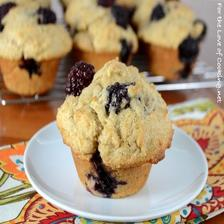

This is a muffin!
Probability: 99.9997%


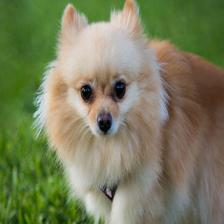

This is a chihuahua!
Probability: 99.9914%


In [5]:
# get interpreted prediction using the predict function
response_muffin = predict(muffin.b)
response_chihuahua = predict(chihuahua.d)

If you downloaded and processed the data,
you can also use all of them by just passing a path to the file to the 
predict function.

If you query the model on images from the train directory,
you are showing the model images it has already seen before.
If you want to see how the model performs on unseen images,
you should use images from the test directory.
The path to the unseen images is stored in the variable `DATA_DIR`.

In [6]:
# check if processed data is available
data_available = DATA_DIR.exists()

if data_available:
    print("✓ Processed data is available!")
    print("  You can use all of the images in the `data/processed/` folder.")
else:
    print("✗ Processed data is not available!")
    print(
        "  Please download and process according to the instructions in the "
        "README!"
    )

✓ Processed data is available!
  You can use all of the images in the `data/processed/` folder.


In case the data is available, the following cell lists all files for both
muffin and chihuahua, and makes them accessible in an object.

In [7]:
if data_available:
    
    # list all image paths and save them to an object
    muffins_all = os.listdir(DATA_DIR / "muffin")
    chihuahuas_all = os.listdir(DATA_DIR / "chihuahua")
    
    # print the paths
    print("Available images:")
    print(f"Muffin: {muffins_all}")
    print(f"Chihuahua: {chihuahuas_all}\n")
    
    # add path to the directory to all image paths
    print("Saved paths:")
    muffins_all = [DATA_DIR / "muffin" / image for image in muffins_all]
    chihuahuas_all = [DATA_DIR / "chihuahua" / image for image in chihuahuas_all]
    
    # print the paths
    print(f"Muffin: {muffins_all}")
    print(f"Chihuahua: {chihuahuas_all}")


Available images:
Muffin: ['img_4_971.jpg', 'img_2_93.jpg', 'img_2_78.jpg', 'img_1_175.jpg', 'img_0_366.jpg', 'img_0_831.jpg', 'img_2_539.jpg', 'img_4_583.jpg', 'img_1_15.jpg', 'img_0_602.jpg', 'img_4_554.jpg', 'img_3_1156.jpg', 'img_4_408.jpg', 'img_3_879.jpg', 'img_2_883.jpg', 'img_1_798.jpg', 'img_3_474.jpg', 'img_2_869.jpg', 'img_4_179.jpg', 'img_3_461.jpg', 'img_4_1126.jpg', 'img_3_449.jpg', 'img_3_1194.jpg', 'img_4_24.jpg', 'img_4_435.jpg', 'img_0_978.jpg', 'img_2_302.jpg', 'img_0_950.jpg', 'img_2_458.jpg', 'img_4_233.jpg', 'img_4_227.jpg', 'img_1_376.jpg', 'img_2_1023.jpg', 'img_4_972.jpg', 'img_4_1050.jpg', 'img_3_1237.jpg', 'img_4_782.jpg', 'img_2_923.jpg', 'img_1_638.jpg', 'img_0_403.jpg', 'img_3_1035.jpg', 'img_0_629.jpg', 'img_4_543.jpg', 'img_2_328.jpg', 'img_2_314.jpg', 'img_2_499.jpg', 'img_1_572.jpg', 'img_3_1182.jpg', 'img_4_26.jpg', 'img_2_116.jpg', 'img_2_857.jpg', 'img_1_770.jpg', 'img_4_608.jpg', 'img_2_671.jpg', 'img_3_462.jpg', 'img_4_1119.jpg', 'img_4_1131.jpg',

Provided you downloaded the data, you can now access the images by indexing
the `muffins_all` and `chihuahuas_all` objects and passing them to the
`predict()` function.

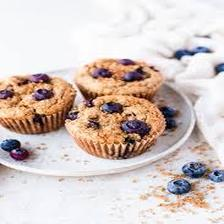

This is a muffin!
Probability: 99.9999%


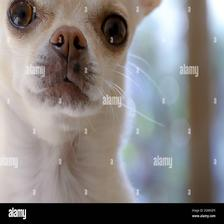

This is a chihuahua!
Probability: 99.9994%


In [8]:
if data_available:

    # predict a muffin image
    predict(muffins_all[13])

    # predict a chihuahua image
    predict(chihuahuas_all[13])


## How to query entirely unseen images

If you want to query with entirely unseen images by passing your own image,
you can do so by using the `predict_user_image` function.
The model expects the image to be a square image with a size of 224x224 pixels
and in the RGB format.
The function `predict_user_image` will check if the image is in the correct
format, reformat it if necessary, and then query the model.

### Example 1: Predicting the Original Meme

This image contains the original meme.
The model has never seen it before.
The file is already contained in the repository, but not in the correct format.

Converting image to correct format.
Saving reformatted image to ../data/user_images/muffin-meme2.jpg


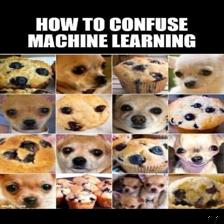

This is a muffin!
Probability: 98.1291%


In [9]:
# the original meme loaded from the images directory
ORIGINAL_MEME = Path("../images/muffin-meme2.jpg")

# predict the original meme
response_original_meme = predict_user_image(ORIGINAL_MEME)

Interesting!
According to the model, this is a muffin!
Also, it is pretty confident about it.
However, this is a panel image, not a single image, so it does not really
correspond to what the model has been trained on.

### Example 2: Predicting your own image

You can also just pass any image from your computer.
The function is able to handle these file formats:

- `.jpg`
- `.jpeg`
- `.png`
- `.bmp`
- `.tiff`
- `.webp`
- `.gif` (first frame only)


Converting image to correct format.
Saving reformatted image to ../data/user_images/Shia_LaBeouf.png


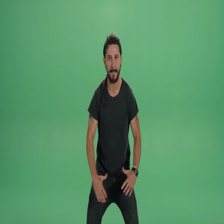

This is a chihuahua!
Probability: 97.3790%


In [10]:
# predict an image from your computer

# path to image
CUSTOM_IMAGE = Path.home() / "Pictures/memes/Shia_LaBeouf.png"

# predict the image
just_do_it = predict_user_image(CUSTOM_IMAGE)


lol - sorry, Shia!

## More about the API

If you are interested in the raw JSON response,
for example because you want to build a JavaScript frontend,
this is how you can have a look at it:

In [11]:
# display JSON response
for key, value in response_muffin.items():
    print(f"{key}: {value}")

print("\n")

for key, value in response_chihuahua.items():
    print(f"{key}: {value}")

class_name: positive
probability: 0.9999966621398926
all_probabilities: {'negative': 3.3225562674488174e-06, 'positive': 0.9999966621398926}


class_name: negative
probability: 0.9999140501022339
all_probabilities: {'negative': 0.9999140501022339, 'positive': 8.600122964708135e-05}


Class `positive` is the muffin, class `negative` is the chihuahua.

You can find FastAPI documentation of the API
[here](http://localhost:8000/docs)
once you host the API.